# GPX elevation
Notebook by [Florian Neukirchen](https://www.riannek.de/). 
For detailed explanation see my blog: https://www.riannek.de/2022/elevation-to-gps-track-python/

In [56]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import elevation
import rasterio

In [57]:
track_in = 'gpx/2021-05-22-163014.gpx' 
track_out = 'test.gpx'

dem_file = '2021-05-22-163014.tif' 
demfolder = "dem" # Where to save the DEM

# Note: this uses GDAL under the hood
# https://gdal.org/drivers/vector/gpx.html
gdf = gpd.read_file(track_in, layer='track_points')

# GDAL returns a lot of useless columns with "None" values
gdf.dropna(axis=1, inplace=True)

# This is important if we want to save as GPX
gdf['time'] = pd.to_datetime(gdf['time'])

gdf.head()

,track_fid,track_seg_id,track_seg_point_id,ele,time,geometry
0,0,0,0,908.0,2021-05-22 14:30:14+00:00,POINT (7.92390 47.69870)
1,0,0,1,908.1,2021-05-22 14:30:20+00:00,POINT (7.92402 47.69866)
2,0,0,2,908.4,2021-05-22 14:30:25+00:00,POINT (7.92412 47.69860)
3,0,0,3,908.7,2021-05-22 14:30:31+00:00,POINT (7.92419 47.69851)
4,0,0,4,908.9,2021-05-22 14:30:36+00:00,POINT (7.92422 47.69843)


In [58]:
gdf.drop(columns='ele', inplace=True)
gdf.head()

,track_fid,track_seg_id,track_seg_point_id,time,geometry
0,0,0,0,2021-05-22 14:30:14+00:00,POINT (7.92390 47.69870)
1,0,0,1,2021-05-22 14:30:20+00:00,POINT (7.92402 47.69866)
2,0,0,2,2021-05-22 14:30:25+00:00,POINT (7.92412 47.69860)
3,0,0,3,2021-05-22 14:30:31+00:00,POINT (7.92419 47.69851)
4,0,0,4,2021-05-22 14:30:36+00:00,POINT (7.92422 47.69843)


In [59]:
# Get the bounds of the track
minx, miny, maxx, maxy = gdf.dissolve().bounds.loc[0]

# You might want to add some margin if you want to use the DEM for other tracks/tasks
minx, miny, maxx, maxy = bounds  = minx - .05, miny - .05, maxx + .05, maxy + .05
bounds

(7.864585, 47.617595, 7.974288, 47.748698999999995)

## Get the DEM

In [60]:
# make sure the dem folder does exist
# (otherwise the module elevation fails)
if not os.path.exists(demfolder):
    os.mkdir(demfolder)
    
# the module elevation does not work with relative paths
dem_file = os.path.join(os.getcwd(), demfolder, dem_file)

In [61]:
# Download DEM 
elevation.clip(bounds=bounds, output=dem_file)

# Clean temporary files
elevation.clean()

make: Verzeichnis „/home/riannek/.cache/elevation/SRTM1“ wird betreten
make: Für das Ziel „download“ ist nichts zu tun.
make: Verzeichnis „/home/riannek/.cache/elevation/SRTM1“ wird verlassen
make: Verzeichnis „/home/riannek/.cache/elevation/SRTM1“ wird betreten
make: Für das Ziel „all“ ist nichts zu tun.
make: Verzeichnis „/home/riannek/.cache/elevation/SRTM1“ wird verlassen
make: Verzeichnis „/home/riannek/.cache/elevation/SRTM1“ wird betreten
cp SRTM1.vrt SRTM1.5ceefc35b896455ca113e71a2f3de3f1.vrt
make: Verzeichnis „/home/riannek/.cache/elevation/SRTM1“ wird verlassen
make: Verzeichnis „/home/riannek/.cache/elevation/SRTM1“ wird betreten
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin 7.864585 47.748698999999995 7.974288 47.617595 SRTM1.5ceefc35b896455ca113e71a2f3de3f1.vrt /home/riannek/code/jupyter-notebooks/runkeeper/dem/2021-05-22-163014.tif
rm -f SRTM1.5ceefc35b896455ca113e71a2f3de3f1.vrt
make: Verzeichnis „/home/riannek/.cache/elevatio

In [62]:
# Open the DEM 
dem_data = rasterio.open(dem_file)

In [63]:
# The CRS is EPSG 4326 = WGS84
# (The same CRS as used by GPS devices)
dem_data.crs

CRS.from_epsg(4326)

In [64]:
dem_data.width

395

In [65]:
dem_data.height

472

In [66]:
dem_data.bounds

BoundingBox(left=7.864583333333334, bottom=47.61763888888889, right=7.974305555555556, top=47.74875)

In [67]:
# It has one channel ...
dem_data.count

1

In [68]:
# ... and we want this channel as array
dem_array = dem_data.read(1)

## Sample the DEM
All the magic is happening here: dem_data.index() takes a set of coordinates and returns the index values of our array. We can use these index values to get the value from the array. Note: GPX uses the tag `<ele></ele>` for elevation.

In [69]:
gdf['ele'] = dem_array[dem_data.index(gdf['geometry'].x , gdf['geometry'].y)]

# Note that we get ele values as int. 
# To save as GPX, ele must be as float.
gdf['ele'] = gdf['ele'].astype(float)

gdf.head()

,track_fid,track_seg_id,track_seg_point_id,time,geometry,ele
0,0,0,0,2021-05-22 14:30:14+00:00,POINT (7.92390 47.69870),908.0
1,0,0,1,2021-05-22 14:30:20+00:00,POINT (7.92402 47.69866),908.0
2,0,0,2,2021-05-22 14:30:25+00:00,POINT (7.92412 47.69860),907.0
3,0,0,3,2021-05-22 14:30:31+00:00,POINT (7.92419 47.69851),907.0
4,0,0,4,2021-05-22 14:30:36+00:00,POINT (7.92422 47.69843),909.0


Since our data was int, the result looks a bit stepped. For a smoother approach see below.

## Implement bilinear interpolation

In [87]:
from scipy.interpolate import interpn



In [85]:
def bilinear(point):
    x_idx, y_idx = dem_data.index(point.x , point.y)
    return (x_idx)

In [86]:
gdf['geometry'].map(bilinear).head()

0    180
1    180
2    180
3    180
4    181
Name: geometry, dtype: int64

## Save as GPX
Note: This fails if the file already exists!

In [70]:
gdf.to_file(track_out, 'GPX', layer='track_points')

## Extra: Plot a profile
To plot a profile, we first need the distance along the track. I project the geometry to UTM to get it in meters. With pyproj >= 3 it is easy to get the UTM zone.

In [71]:
profile = gdf[['geometry', 'ele']]
profile = profile.to_crs(profile.estimate_utm_crs())

We use a shifted GeoDataFrame (shift index by 1) to easily calculate the distance from point to point

In [72]:
shifted = profile.shift()

/home/riannek/miniconda3/envs/elevation/lib/python3.11/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / UTM zone 32N (the single non-null crs provided).
  warnings.warn(


In [73]:
profile['distance'] = profile.distance(shifted)
profile['distance'] = profile['distance'].fillna(value=0)
profile['distance'] = profile['distance'].cumsum()
profile['distance'] = profile['distance']/1000 # distance in km

In [74]:
profile.drop(columns='geometry', inplace=True)

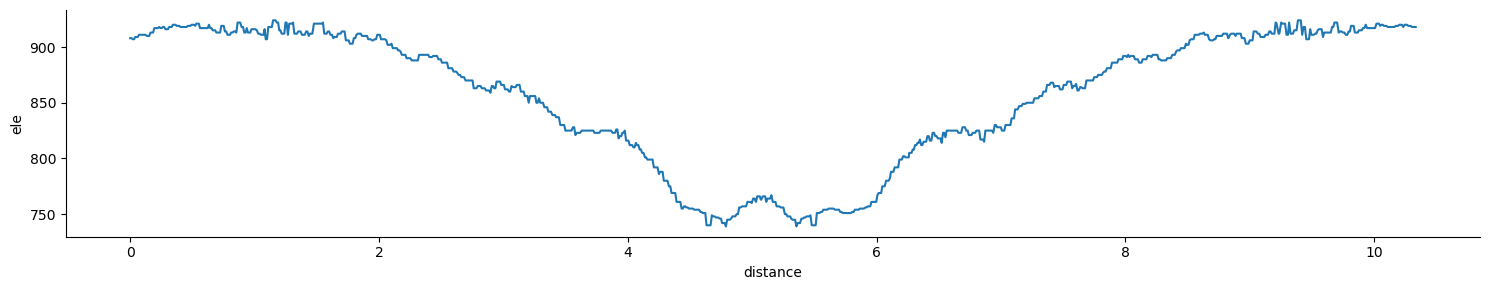

In [75]:
import seaborn as sns
sns.relplot(x="distance", y="ele", data=profile, kind='line', height=3, aspect=5);

## Extra: Have a look at the DEM

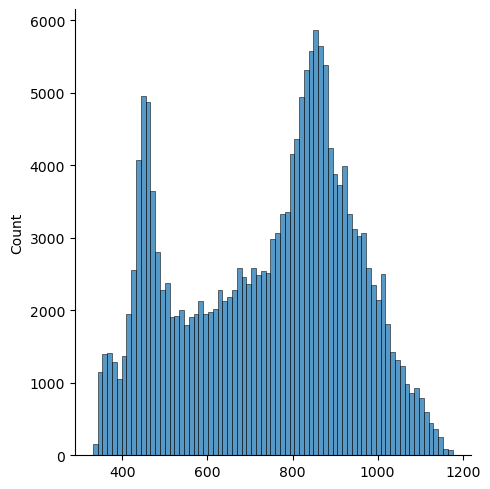

In [76]:
# Histplot of elevations
sns.displot(dem_array.ravel())

<AxesSubplot: >

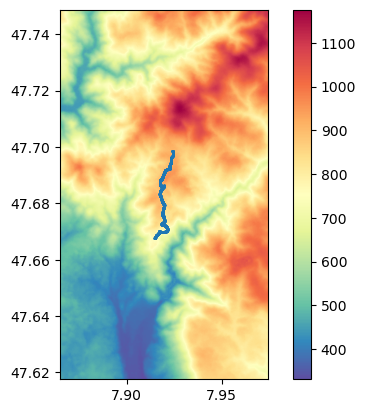

In [77]:
import matplotlib.pyplot as plt

vmin = dem_array.min()
vmax = dem_array.max()
extent = minx, maxx, miny, maxy

fig, ax = plt.subplots()
cax = plt.imshow(dem_array, extent=extent, 
                  cmap='Spectral_r', vmin=vmin, vmax=vmax)
fig.colorbar(cax, ax=ax)
gdf.plot(ax=ax, markersize=1, zorder=11)

## Get smoother elevation

In [78]:
upscale_factor = 5

dem_array_float = dem_array.astype(float)

from scipy import ndimage

# Blur to reduce the steps in the DEM.
# With sigma 0.33 I am still very close to the original.
dem_array_float = ndimage.gaussian_filter(dem_array_float, sigma=0.33)

# Upscale the array
# Note: zoom() resamples with cubic interpolation with order=3 (default) 
dem_array_float = ndimage.zoom(dem_array_float, upscale_factor).round(decimals=1)


# Scale the transform matrix
transform = dem_data.transform * dem_data.transform.scale(
        (dem_data.width / dem_array_float.shape[-1]),
        (dem_data.height / dem_array_float.shape[-2])
    )

In [79]:
gdf['ele_resample'] = dem_array_float[rasterio.transform.rowcol(transform, gdf['geometry'].x, gdf['geometry'].y)]
gdf.head()

,track_fid,track_seg_id,track_seg_point_id,time,geometry,ele,ele_resample
0,0,0,0,2021-05-22 14:30:14+00:00,POINT (7.92390 47.69870),908.0,907.9
1,0,0,1,2021-05-22 14:30:20+00:00,POINT (7.92402 47.69866),908.0,907.7
2,0,0,2,2021-05-22 14:30:25+00:00,POINT (7.92412 47.69860),907.0,907.3
3,0,0,3,2021-05-22 14:30:31+00:00,POINT (7.92419 47.69851),907.0,907.8
4,0,0,4,2021-05-22 14:30:36+00:00,POINT (7.92422 47.69843),909.0,908.1


Profile:

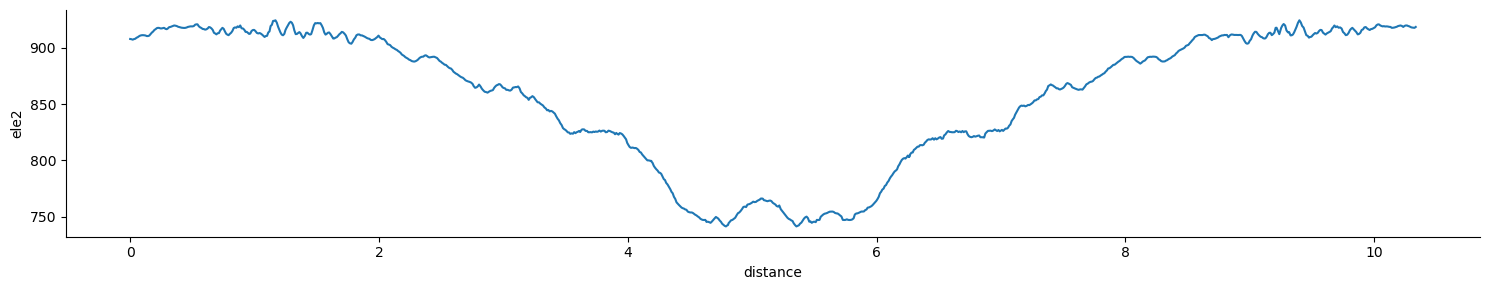

In [80]:
profile['ele2'] = gdf['ele_resample']
sns.relplot(x="distance", y="ele2", data=profile, kind='line', height=3, aspect=5);

Both profiles:

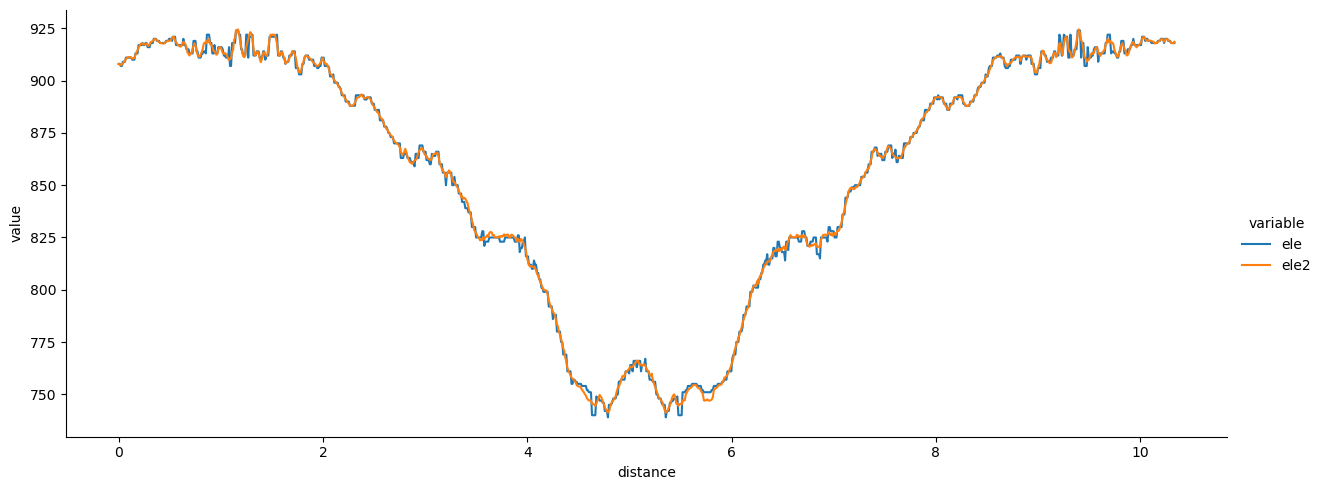

In [81]:
sns.relplot(x="distance", y="value", data=profile.melt(id_vars='distance'), hue='variable', kind='line', aspect=2.5);